In [1]:
import sys
import numpy as np
import xarray as xr
from glob import glob
from scipy.io import loadmat
from scipy.optimize import curve_fit
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import gsw
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
from xgcm import Grid 
from jmd95 import densjmd95
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [4]:
# LLC270 (load steric height and steric pressure already computed) 
files = glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/' + '/raw_270_ts*.nc')
files = np.sort(files); count = 0
for i in range(len(files)):
    this_file = xr.open_dataset(files[i]);
    if count < 1:
        ds_theta = this_file.theta
        ds_salt = this_file.salt
    else:
        ds_theta = xr.concat([ds_theta, this_file.theta], dim="time")
        ds_salt = xr.concat([ds_salt, this_file.salt], dim="time")
    print(files[i])
    count = count + 1

/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/raw_270_ts_2008_2009.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/raw_270_ts_2010_2011.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/raw_270_ts_2012_2013.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/raw_270_ts_2014_2015.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/ts/raw_270_ts_2016_2017.nc


In [5]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [6]:
tile_num = 10
g = 9.81; rho0 = 1029;
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 

In [7]:
# -- Gulf of Mexico Mask -- 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_grid.XC.i.data), j=(["j"], ecco_grid.XC.j.data),
        XC=(["j","i"], ecco_grid.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_grid.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

da_gulf_mask = xr.DataArray(data=np.transpose(gulf_mask.data), dims=["lat","lon"],
                        coords=dict(
                            lon=(["lon"], np.nanmean(gulf_mask.XC,axis=1)),
                            lat=(["lat"], np.nanmean(gulf_mask.YC,axis=0)),
                        ),
                       )
gulf_area = np.nansum(gulf_mask*ecco_grid.rA.isel(tile=tile_num))

In [8]:
p = gsw.p_from_z(ecco_grid.Z, ecco_grid.YC.isel(tile=tile_num)) # .isel(tile=tile_num)
z = gsw.z_from_p(p, ecco_grid.YC.isel(tile=tile_num))

salt = ds_salt*gulf_mask
salt = salt.where(salt>0, np.nan)
# salt_const = 33*salt.copy()

theta = ds_theta*gulf_mask
theta = theta.where(theta>0, np.nan)
# theta_const = 20*theta.copy()

In [9]:
time_ord = np.nan*np.ones(len(salt.time))
for i in range(len(salt.time)):
    ts = (np.datetime64(str(salt.time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)

In [ ]:
salt = salt.rename({'layer': 'k'})
theta = theta.rename({'layer': 'k'})

In [29]:
# single iteration test 
j = 105; i = 240;
SA = gsw.SA_from_SP(salt[:,:,j,i],p[:,j,i],lons[j,i],lats[j,i])
CT = gsw.CT_from_pt(SA,theta[:,:,j,i])
beta = gsw.beta(SA,CT,p[:,j,i])
alpha = gsw.alpha(SA,CT,p[:,j,i])
delta_salt = SA - SA.mean(dim='time')
delta_theta = CT - CT.mean(dim='time')
test = ((delta_salt*beta)*ecco_grid.hFacC.isel(tile=tile_num)[:,j,i]*ecco_grid.drF).sum(dim='k')

In [79]:
T_0 = 22 
S_0 = 30

In [80]:
delta_eta_s = np.nan*salt[:,0].copy()
delta_eta_t = np.nan*salt[:,0].copy()
ct_a = np.nan*salt.copy()
sa_a = np.nan*salt.copy()
for j in range(80,160):
    for i in range(190,270):
        if ~np.isnan(salt[0,0,j,i]):
            SA = gsw.SA_from_SP(salt[:,:,j,i],p[:,j,i],lons[j,i],lats[j,i])
            CT = gsw.CT_from_pt(SA,theta[:,:,j,i])
            beta = gsw.beta(SA,CT,p[:,j,i])
            alpha = gsw.alpha(SA,CT,p[:,j,i])
            delta_salt = SA - SA.mean(dim='time')
            delta_theta = CT - CT.mean(dim='time')
            ct_a[:,:,j,i] = delta_theta
            sa_a[:,:,j,i] = delta_salt
            delta_eta_s[:,j,i] = ((beta*(SA - S_0))*ecco_grid.hFacC.isel(tile=tile_num)[:,j,i]*ecco_grid.drF).sum(dim='k')
            delta_eta_t[:,j,i] = ((alpha*(CT - T_0))*ecco_grid.hFacC.isel(tile=tile_num)[:,j,i]*ecco_grid.drF).sum(dim='k')

In [63]:
ct_a_GoM = (ct_a*gulf_mask.data*ecco_grid.rA.isel(tile=tile_num)).sum(dim=['i','j'])/gulf_area 

In [71]:
sa_a_GoM = (sa_a*gulf_mask.data*ecco_grid.rA.isel(tile=tile_num)).sum(dim=['i','j'])/gulf_area 

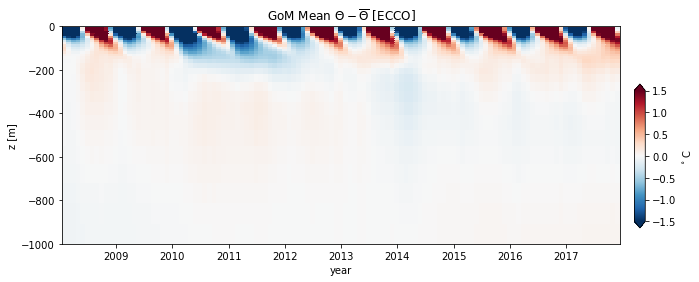

In [66]:
f, ax = plt.subplots(1,1,figsize=(10,4))
cc = ax.pcolor(ct_a.time, ecco_grid.Z, ct_a_GoM.transpose(), cmap='RdBu_r', vmin=-1.5, vmax=1.5)
ax.set_title(r'GoM Mean $\Theta - \overline{\Theta}$ [ECCO]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); 
ax.set_ylim([-1000,0]); # ax.set_xlim([t_rec[0], t_rec[-1]]); 
cbpos = [0.92, 0.18, 0.015, 0.5]; 
cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label=r'$^{\circ}}$ C')

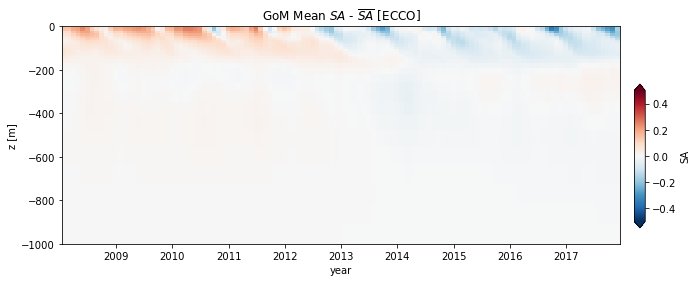

In [74]:
f, ax = plt.subplots(1,1,figsize=(10,4))
cc = ax.pcolor(ct_a.time, ecco_grid.Z, sa_a_GoM.transpose(), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax.set_title(r'GoM Mean $SA$ - $\overline{SA}$ [ECCO]')
ax.set_ylabel('z [m]'); ax.set_xlabel('year'); 
ax.set_ylim([-1000,0]); # ax.set_xlim([t_rec[0], t_rec[-1]]); 
cbpos = [0.92, 0.18, 0.015, 0.5]; 
cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label=r'SA')

In [151]:
# OLD multiply by GoM mask and only compute density where non-nan
salt_const = (0*salt.copy()) + (salt.mean(dim='time'))
time0 = time.time()
rho_jmd95 = np.nan*salt.copy()
rho_jmd95_s_const = np.nan*salt.copy()
rho_jmd95_t_const = np.nan*salt.copy()
for i in range(np.shape(rho_jmd95)[2]):
    for j in range(np.shape(rho_jmd95)[3]):
        if ~np.isnan(salt[0,0,i,j]):
            rho_jmd95[:,:,i,j] = densjmd95(salt[:,:,i,j],theta[:,:,i,j],p[:,i,j])
            rho_jmd95_s_const[:,:,i,j] = densjmd95(salt_const[:,:,i,j],theta[:,:,i,j],p[:,i,j])
            # rho_jmd95_t_const[:,:,i,j] = densjmd95(salt[:,:,i,j],theta_const[:,:,i,j],p[:,i,j])
elapsed = time.time() - time0
print(elapsed) # in seconds 

60.46590304374695


In [173]:
ecco_grid.Z[37].data

array(-2084.035, dtype=float32)

In [174]:
# OLD steric height
# rho_jmd95 = rho_jmd95.rename({'layer': 'k'})
# rho_jmd95_s_const = rho_jmd95_s_const.rename({'layer': 'k'})
# rho_jmd95_t_const = rho_jmd95_t_const.rename({'layer': 'k'})
# -- integrate down to ___ m -- 
lower_lim_i = 33 # 33=1500,37=2000m
steric_height = (-1/rho0)*((rho_jmd95[:,0:lower_lim_i]-rho0)*ecco_grid.hFacC.isel(tile=tile_num)[0:lower_lim_i]*ecco_grid.drF[0:lower_lim_i]).sum(dim='k')
steric_height_s_const = (-1/rho0)*((rho_jmd95_s_const[:,0:lower_lim_i]-rho0)*ecco_grid.hFacC.isel(tile=tile_num)[0:lower_lim_i]*ecco_grid.drF[0:lower_lim_i]).sum(dim='k')
# steric_height_t_const = (-1/124571)*((rho_jmd95_t_const-124571)*ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF).sum(dim='k')

In [175]:
# joint fit to get trend 
time0 = time.time()
pes = np.nan*(delta_eta_s.sel(time='2008-01-16').copy()).squeeze()
pes_s_const = np.nan*(delta_eta_s.sel(time='2008-01-16').copy()).squeeze()
pes_t_const = np.nan*(delta_eta_s.sel(time='2008-01-16').copy()).squeeze()
for j in range(80,160):
    for i in range(190,270):
        if np.sum(np.isnan((delta_eta_s*ocean_mask.sel(tile=tile_num))[:,j,i])) < 1:
            fit = curve_fit(seasonal_plus_trend, time_ord - time_ord[0], (steric_height*ocean_mask.sel(tile=tile_num))[:,j,i])
            pes[j,i] = fit[0][4]*365*1000
            fit1 = curve_fit(seasonal_plus_trend, time_ord - time_ord[0], (steric_height_s_const*ocean_mask.sel(tile=tile_num))[:,j,i])
            pes_s_const[j,i] = fit1[0][4]*365*1000
            
            # steric_height = -1*(delta_eta_s[:,j,i] + delta_eta_t[:,j,i])
            # fit = curve_fit(seasonal_plus_trend, time_ord - time_ord[0], (steric_height*ocean_mask.sel(tile=tile_num))[:,j,i])
            # pes[j,i] = fit[0][4]*365*1000
            
            # fit1 = curve_fit(seasonal_plus_trend, time_ord - time_ord[0], (-1*delta_eta_s*ocean_mask.sel(tile=tile_num))[:,j,i])
            # pes_s[j,i] = fit1[0][4]*365*1000
            
            # fit2 = curve_fit(seasonal_plus_trend, time_ord - time_ord[0], (-1*delta_eta_t*ocean_mask.sel(tile=tile_num))[:,j,i])
            # pes_t[j,i] = fit2[0][4]*365*1000
elapsed = time.time() - time0
print(elapsed) # in seconds 

121.6357011795044


In [154]:
np.nanmean(pes_s_const)

2.5217538

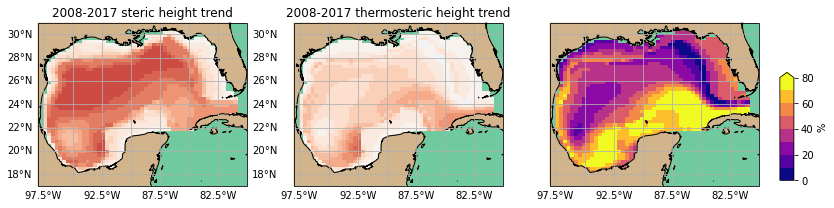

In [176]:
colMapse = plt.get_cmap('RdBu_r',30); colMapse.set_over(color='#660000');
cmin = -15; cmax = 15;

f, (ax1,ax2,ax4) = plt.subplots(1,3,figsize=(13,3), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax1.pcolor(lons, lats, pes, transform=ccrs.PlateCarree(), cmap=colMapse, vmin=cmin, vmax=cmax); 
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); 
ax1.coastlines(); ax1.grid(); 
ax1.set_title('2008-2017 steric height trend')
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; 
ax1.set_facecolor('#6fcb9f'); 
ax1.set_xlim([lon_w, lon_e]); ax1.set_ylim([lat_s, lat_n]);

ax2.pcolor(lons, lats, pes_s_const, transform=ccrs.PlateCarree(), cmap=colMapse, vmin=cmin, vmax=cmax); 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); 
ax2.coastlines(); ax2.grid(); 
ax2.set_title('2008-2017 thermosteric height trend')
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False;
ax2.set_facecolor('#6fcb9f'); 
ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n]);

# ax3.pcolor(lons, lats, pes_t, transform=ccrs.PlateCarree(), cmap=colMapse, vmin=cmin, vmax=cmax); 
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); 
ax3.coastlines(); ax3.grid(); 
gl = ax3.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False;
ax3.set_facecolor('#6fcb9f'); 
ax3.set_xlim([lon_w, lon_e]); ax3.set_ylim([lat_s, lat_n]);

cc = ax4.pcolor(lons, lats, 100*pes_s_const/pes, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('plasma',8), vmin=0, vmax=80); 
# ax4.contour(lons, lats, 100*pes_s_const/pes, levels=[25,50], colors='k')
ax4.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); 
ax4.coastlines(); ax4.grid(); 
gl = ax4.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False;
ax4.set_facecolor('#6fcb9f'); 
ax4.set_xlim([lon_w, lon_e]); ax4.set_ylim([lat_s, lat_n]);
cbpos = [0.92, 0.15, 0.015, 0.5]; 
cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='max', label=r'%')

In [179]:
print(((pes*gulf_mask.data*ecco_grid.rA.isel(tile=tile_num)).sum(dim=['i','j'])/gulf_area).data)
print(((pes_s_const*gulf_mask.data*ecco_grid.rA.isel(tile=tile_num)).sum(dim=['i','j'])/gulf_area).data)

6.057367
2.685165


In [12]:
# rho_jmd95 = densjmd95(salt,theta,p)
# rho_jmd95_salt_const = densjmd95(salt_const,ds_den,p)
# rho_jmd95_theta_const = densjmd95(salt,theta_const,p)

In [ ]:
# STERIC -- FOR LLC 270 only 1 tile 
rho_pr_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3]))
rho_int_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd[i] = np.sum((rho_jmd95[i]-rho0)*ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF, axis=0) # .isel(tile=tile_num)
    rho_int_jmd[i] = np.sum((rho_jmd95[i])*ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF, axis=0) # .isel(tile=tile_num)
steric_height_jmd = (-1/rho0)*rho_pr_jmd